# Keck 2 Polarization Model

Here we create a model of the Keck 2 telescope + AO Bench to determine the transformation of the generally polarized field through the system. We've loaded a poke.Rayfront generated on a windows maching using a Zemax OpticStudio (ZOS) raytrace of the observatory.

In [101]:
from poke.writing import read_serial_to_rayfront
from hcipy import *
from poke.interfaces import rayfront_to_hcipy_wavefront
import poke.plotting as plot
from poke.poke_math import np
from scipy.ndimage import center_of_mass
import matplotlib.pyplot as plt
pth = 'rayfronts/k2_orkid_600nm_nobeamsplitters.msgpack'
rf = read_serial_to_rayfront(pth)

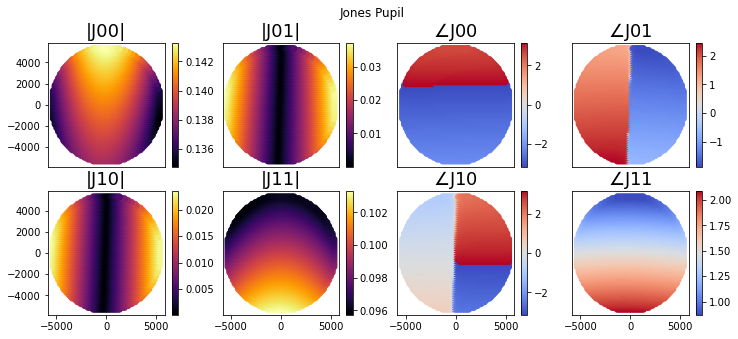

In [102]:
plot.jones_pupil(rf)

## More realistic Coatings
I used a dummy coating of n = 0.4 + 7i on the prior coating just to generate something but we should model the observatory more realistically. What materials do we need?

**The Telescope**
- M1: https://www.keckobservatory.org/keeping_keck_telescopes_shiny/ claims that the primary mirror is aluminum, maybe it's a safe bet to just use Al for the observatory optics?

In [103]:
# # now we want to twist a half waveplate, so update the HWP model
# angles = np.linspace(0,2*np.pi,25)

# # Set up the HCIPy stuff
# npix = 1024
# pupil_grid = make_pupil_grid(npix)
# aperture = make_elt_aperture(True)(pupil_grid)
# # Unpolarized Star
# stokes_vector_planet = [1, 0.1, 0, 0]
# contrast = 2e-4
# angular_separation = 3 # lambda / D
# num_photons_star = 1e9
# focal_grid = make_focal_grid(8, 8)
# prop = FraunhoferPropagator(pupil_grid, focal_grid)
# beamshifts = []
# diffplots = []

# for angle in angles:

#     # update hwp
#     hwp = rotmat2d(angle) @ np.array([[1,0],[0,np.exp(1j*np.pi/2)]]) @ rotmat2d(angle)

#     # update surfdict
#     k1 = {'coating':hwp,'surf':10,'mode':'reflect'} # Al

#     # update surfface list
#     rf.surfaces = [m1,m2,m3,k1,k2,k3,tt,o1,pu,o2,di,sod,ifm,afm]

#     # compute jones pupil
#     rf.compute_jones_pupil(aloc=a,exit_x=x)
#     # Convert to hcipy wavefront
#     partially_polarized_wavefront = rayfront_to_hcipy_wavefront(rf,npix,pupil_grid,input_stokes_vector=[1,0,0,0])
#     partially_polarized_wavefront.electric_field *= aperture # apply the magellan aperture
#     # Apply to a star and a planet
#     wf_star = partially_polarized_wavefront #(aperture)
#     wf_star.total_power = num_photons_star
#     jones_matrix = partially_polarized_wavefront.electric_field

#     e_planet = aperture * np.exp(2j * np.pi * pupil_grid.x * angular_separation)
#     wf_planet = Wavefront(jones_matrix*e_planet, input_stokes_vector=stokes_vector_planet)
#     wf_planet.total_power = num_photons_star * contrast
    
#     pbs = LinearPolarizingBeamSplitter(0)

#     img_star_1, img_star_2 = pbs((prop(wf_star)))
#     img_planet_1, img_planet_2 = pbs((prop(wf_planet)))

#     science_image_1 = img_star_1.power + img_planet_1.power
#     science_image_2 = img_star_2.power + img_planet_2.power

#     science_image_1 = large_poisson(science_image_1)
#     science_image_2 = large_poisson(science_image_2)

#     # compute the differential beamshift
#     com1 = center_of_mass(np.array(science_image_1.shaped))
#     com2 = center_of_mass(np.array(science_image_2.shaped))
#     beamshift = np.sqrt((com1[0]-com2[0])**2 + (com1[1] - com2[1])**2)
#     beamshifts.append(beamshift/8 * 1.550e-6 / 10.95 * 206265)
#     diffplots.append(np.array((science_image_1.shaped - science_image_2.shaped) / science_image_1.max()))

In [104]:
# from github.com/ehpor/hcipy

def make_keck_aperture(normalized=False, with_spiders=True, with_segment_gaps=True, gap_padding=10, segment_transmissions=1, return_segments=False):
    """Make the Keck aperture.

    This code creates a Keck-like aperture matching values used in [vanKooten2022a] and [vanKooten2022b] as well as
    being verified by Keck personnel to match internal simulation efforts.

    .. [vanKooten2022a] Maaike van Kooten et al., "Predictive wavefront control on Keck II adaptive optics bench: on-sky coronagraphic results." JATIS 8 (2022): 029006
    .. [vanKooten2022b] Maaike van Kooten et al., "On-sky Reconstruction of Keck Primary Mirror Piston Offsets Using a Zernike Wavefront Sensor." The Astrophysical Journal 932 (2022): 2, 109.

    Parameters
    ----------
    normalized : boolean
        If this is True, the outer diameter will be scaled to 1. Otherwise, the
        diameter of the pupil will be 10.95 meters.
    with_spiders : boolean
        Include the secondary mirror support structure in the aperture.
    with_segment_gaps : boolean
        Include the gaps between individual segments in the aperture.
    gap_padding : scalar
        Arbitrary padding of gap size to represent gaps on smaller arrays - this effectively
        makes the gaps larger and the segments smaller to preserve the same segment pitch.
    segment_transmissions : scalar or array_like
        The transmission for each of the segments. If this is a scalar, this transmission
        will be used for all segments.
    return_segments : boolean
        If this is True, the segments will also be returned as a list of Field generators.

    Returns
    -------
    aperture : Field generator
        The Keck aperture.
    segments : list of Field generators
        The segments. Only returned when `return_segments` is True.
    """
    pupil_diameter = 10.95  # m actual circumscribed diameter
    actual_segment_flat_diameter = np.sqrt(3) / 2 * 1.8  # m actual segment flat-to-flat diameter
    central_obscuration_diameter = 2.6  # m
    actual_segment_gap = 0.003  # m actual gap size between segments
    spider_width = 2.6e-2  # m actual strut size
    num_rings = 3  # number of full rings of hexagons around central segment

    if normalized:
        actual_segment_flat_diameter /= pupil_diameter
        actual_segment_gap /= pupil_diameter
        spider_width /= pupil_diameter
        central_obscuration_diameter /= pupil_diameter
        pupil_diameter = 1.0

    # padding out the segmentation gaps so they are visible and not sub-pixel
    segment_gap = actual_segment_gap * gap_padding
    if not with_segment_gaps:
        segment_gap = 0

    segment_flat_diameter = actual_segment_flat_diameter - (segment_gap - actual_segment_gap)
    segment_circum_diameter = 2 / np.sqrt(3) * segment_flat_diameter

    segment_positions = make_hexagonal_grid(actual_segment_flat_diameter + actual_segment_gap, num_rings)

    segment = make_hexagonal_aperture(segment_circum_diameter, np.pi / 2)

    if with_spiders:
        spider1 = make_spider_infinite([0, 0], 0, spider_width)
        spider2 = make_spider_infinite([0, 0], 60, spider_width)
        spider3 = make_spider_infinite([0, 0], 120, spider_width)
        spider4 = make_spider_infinite([0, 0], 180, spider_width)
        spider5 = make_spider_infinite([0, 0], 240, spider_width)
        spider6 = make_spider_infinite([0, 0], 300, spider_width)

    segmented_aperture = make_segmented_aperture(segment, segment_positions, segment_transmissions, return_segments=return_segments)
    if return_segments:
        segmented_aperture, segments = segmented_aperture

    def func(grid):
        res = segmented_aperture(grid) * (1 - make_circular_aperture(central_obscuration_diameter)(grid))

        if with_spiders:
            res *= spider1(grid) * spider2(grid) * spider3(grid) * spider4(grid) * spider5(grid) * spider6(grid)

        return Field(res, grid)

    if with_spiders and return_segments:
        # Use function to return the lambda, to avoid incorrect binding of variables
        def segment_with_spider(segment):
            return lambda grid: segment(grid) * spider1(grid) * spider2(grid) * spider3(grid) * spider4(grid) * spider5(grid) * spider6(grid)

        segments = [segment_with_spider(s) for s in segments]

    if return_segments:
        def segment_with_central_obscuration(segment):
            return lambda grid: segment(grid) * (1 - make_circular_aperture(central_obscuration_diameter)(grid))

        segments = [segment_with_central_obscuration(segment) for segment in segments]

        return func, segments
    else:
        return func

Now we construct a polarization model with HCIPy, follow the example!

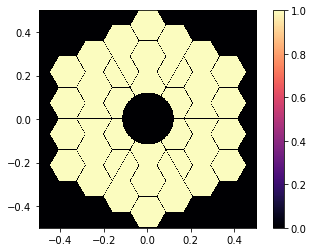

In [105]:
npix = 1024
pupil_grid = make_pupil_grid(npix)
aperture = make_keck_aperture(True)(pupil_grid)

plt.figure()
imshow_field(aperture)
plt.colorbar()
plt.show()

<ipython-input-106-3dc7627c3282>:4: RuntimeWarning: invalid value encountered in divide
  imshow_field(partially_polarized_wavefront.intensity/aperture)


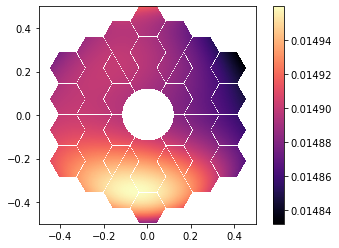

In [106]:
partially_polarized_wavefront = rayfront_to_hcipy_wavefront(rf,npix,pupil_grid,input_stokes_vector=[1,0,0,0]) # assumes an unpolarized input
partially_polarized_wavefront.electric_field *= aperture # apply the keck aperture
plt.figure()
imshow_field(partially_polarized_wavefront.intensity/aperture)
plt.colorbar()
plt.show()

In [107]:
focal_grid = make_focal_grid(8, 8)
prop = FraunhoferPropagator(pupil_grid, focal_grid)
partially_polarized_image = prop(partially_polarized_wavefront)

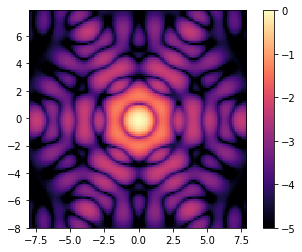

In [108]:
# Unpolarized Star
stokes_vector_planet = [1, 0.1, 0, 0]
contrast = 1e-3
angular_separation = 3 # lambda / D
num_photons_star = 1e9

wf_star = partially_polarized_wavefront #(aperture)
wf_star.total_power = num_photons_star
jones_matrix = partially_polarized_wavefront.electric_field

e_planet = aperture * np.exp(2j * np.pi * pupil_grid.x * angular_separation)
wf_planet = Wavefront(jones_matrix*e_planet, input_stokes_vector=stokes_vector_planet)
wf_planet.total_power = num_photons_star * contrast

# Calculate science image for the star and planet
science_image = prop(wf_star).power
science_image += prop(wf_planet).power

# Simulate photon noise
science_image = large_poisson(science_image)

imshow_field(np.log10(science_image / science_image.max() + 1e-20), vmin=-5, vmax=0)
plt.colorbar()
plt.show()

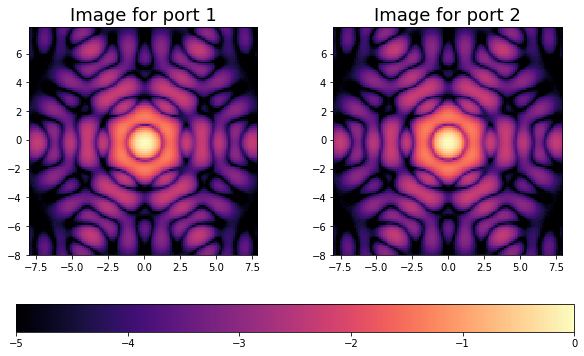

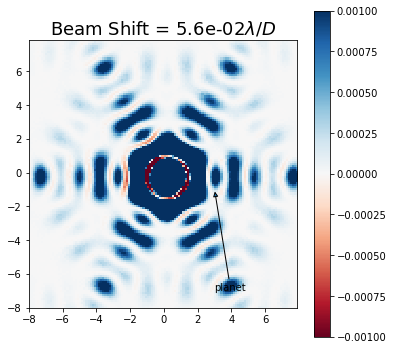

In [109]:
pbs = LinearPolarizingBeamSplitter(100)

img_star_1, img_star_2 = pbs(prop(wf_star))
img_planet_1, img_planet_2 = pbs(prop(wf_planet))

science_image_1 = img_star_1.power + img_planet_1.power
science_image_2 = img_star_2.power + img_planet_2.power

science_image_1 = large_poisson(science_image_1)
science_image_2 = large_poisson(science_image_2)

fig, axes = plt.subplots(figsize=(10, 6), nrows=1, ncols=2)

axes[0].set_title('Image for port 1')
imshow_field(np.log10(science_image_1 / science_image_1.max() + 1e-20), vmin=-5, vmax=0, ax=axes[0])

axes[1].set_title('Image for port 2')
imshow_field(np.log10(science_image_2 / science_image_2.max() + 1e-20), vmin=-5, vmax=0, ax=axes[1])

plt.colorbar(ax=axes.tolist(), orientation="horizontal")
plt.show()

# compute the differential beamshift
from scipy.ndimage import center_of_mass
com1 = center_of_mass(np.array(science_image_1.shaped))
com2 = center_of_mass(np.array(science_image_2.shaped))
beamshift = np.sqrt((com1[0]-com2[0])**2 + (com1[1] - com2[1])**2)

plt.figure(figsize=[6,6])
plt.title(f'Beam Shift = {beamshift/8:.1e}'+r'$\lambda/D$')
imshow_field((science_image_1 - science_image_2) / science_image_1.max(), cmap='RdBu',vmin=-1e-3,vmax=1e-3)
plt.annotate('planet', xy=(3, -1), xytext=(3, -7), arrowprops={'arrowstyle': '-|>'})
plt.colorbar()
plt.show()

In [110]:
# try beamshift v.s. polarizer angle
angles = np.linspace(0,np.pi/2,100)
beamshifts = []
diffplots = []
LD_to_MAS = 600e-9 / 10.96 * 206265 * 1e3
for angle in angles:
    hwp = HalfWavePlate(angle)
    pbs = LinearPolarizingBeamSplitter(0)

    img_star_1, img_star_2 = pbs(hwp(prop(wf_star)))
    img_planet_1, img_planet_2 = pbs(hwp(prop(wf_planet)))

    science_image_1 = img_star_1.power + img_planet_1.power
    science_image_2 = img_star_2.power + img_planet_2.power

    science_image_1 = large_poisson(science_image_1)
    science_image_2 = large_poisson(science_image_2)

    

    # compute the differential beamshift
    com1 = center_of_mass(np.array(science_image_1.shaped))
    com2 = center_of_mass(np.array(science_image_2.shaped))
    beamshift = np.sqrt((com1[0]-com2[0])**2 + (com1[1] - com2[1])**2)
    beamshifts.append(beamshift / 8 * LD_to_MAS )
    diffplots.append(np.array((science_image_1.shaped - science_image_2.shaped) / science_image_1.max()))


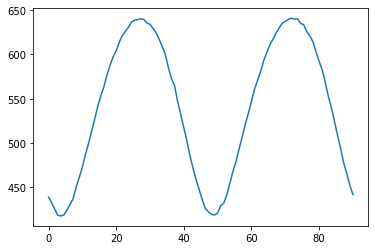

In [111]:
plt.plot(np.degrees(angles),[i*1e3 for i in beamshifts])

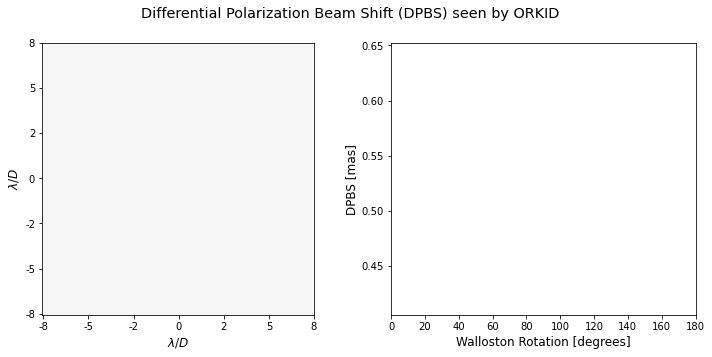

In [113]:
from matplotlib import animation
from IPython.display import HTML
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

cbar_limits = 1e-2

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=[12,5])

# # Initialize the line plot
line, = ax2.plot(angles, beamshifts, 'r-', lw=2)

# # Set up the imshow plot
im = ax1.imshow(np.zeros_like(np.array(science_image_2.shaped)),cmap='RdBu',vmin=-cbar_limits,vmax=cbar_limits, animated=True)

# Define the initialization function
def init():
    im.set_array(np.zeros_like(np.array(science_image_2.shaped)))  # Set initial data for imshow plot
    line.set_data([], [])  # Clear line plot
    return im , line

# Define the update function for the animation
def update(i):
    # Update data for imshow plot
    im.set_array(diffplots[i])
    
    # Update data for line plot
    line.set_data(np.degrees(angles)[:i]*2, beamshifts[:i])
    
    return im , line

# Create the animation

# make it pretty
fs = 12
ticks = np.linspace(-8,8,7)
tickpos = np.linspace(0,128,7)
ticks = [int(i) for i in ticks]
ax2.set_xlim([0,180])
ax1.set_xticks(tickpos)
ax1.set_xticklabels(ticks)
ax1.set_yticks(tickpos)
ax1.set_yticklabels(ticks)
ax2.set_ylabel('DPBS '+'[mas]',fontsize=fs)
ax1.set_xlabel(r'$\lambda/D$',fontsize=fs)
ax1.set_ylabel(r'$\lambda/D$',fontsize=fs)
ax2.set_xlabel('Walloston Rotation [degrees]',fontsize=fs)
ax1_divider = make_axes_locatable(ax1)
# Add an Axes to the right of the main Axes.
# cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
# fig.colorbar(im,cax=cax1)
plt.suptitle('Differential Polarization Beam Shift (DPBS) seen by ORKID',fontsize=fs*1.2)
ani = animation.FuncAnimation(fig, update, frames=len(diffplots), interval=20, init_func=init)
HTML(ani.to_html5_video())

In [114]:
ani.save('orkid_dpbs.gif')

# Now we try an actual polarimeter
Measure the linear polarization from the data supplied. This uses the last rayfront from above.

In [115]:
# Convert to hcipy wavefront
# Apply to a star and a planet
wf_star = partially_polarized_wavefront #(aperture)
wf_star.total_power = num_photons_star
jones_matrix = partially_polarized_wavefront.electric_field

e_planet = aperture * np.exp(2j * np.pi * pupil_grid.x * angular_separation)
wf_planet = Wavefront(jones_matrix*e_planet, input_stokes_vector=stokes_vector_planet)
wf_planet.total_power = num_photons_star * contrast

pbs = LinearPolarizingBeamSplitter(0)

img_star_1, img_star_2 = pbs((prop(wf_star)))
img_planet_1, img_planet_2 = pbs((prop(wf_planet)))

science_image_1 = img_star_1.power + img_planet_1.power
science_image_2 = img_star_2.power + img_planet_2.power

science_image_1 = large_poisson(science_image_1)
science_image_2 = large_poisson(science_image_2)

In [116]:
# Set up the polarimeter pieces
HWP = HalfWavePlate(0)

HWP_positions = [0, 45, 22.5, 67.5] # degrees

polarizer = LinearPolarizer(0)

detector = NoisyDetector(focal_grid, dark_current_rate=0, read_noise=0, flat_field=0, include_photon_noise=False)

In [117]:
# Set up the star
zero_magnitude_flux = 3.9E10 # photons / sec
stellar_magnitude = 8

# the polarization state of the starlight
stokes_vector_star = np.array([1,0.5,0.05,0.01])

# use the poke jones pupil
partially_polarized_wavefront = rayfront_to_hcipy_wavefront(rf,npix,pupil_grid,input_stokes_vector=stokes_vector_star)
partially_polarized_wavefront.electric_field *= aperture # apply the magellan aperture
partially_polarized_wavefront.total_power = zero_magnitude_flux * 10**(-stellar_magnitude / 2.5)

# Assume no polarization aberration
pupil_wavefront = Wavefront(aperture, 1, input_stokes_vector=stokes_vector_star)
pupil_wavefront.total_power = zero_magnitude_flux * 10**(-stellar_magnitude / 2.5)


print("Total photon flux {:g} photons / sec.".format(partially_polarized_wavefront.total_power))

Total photon flux 2.46073e+07 photons / sec.


# Check the polarization state of the pupil

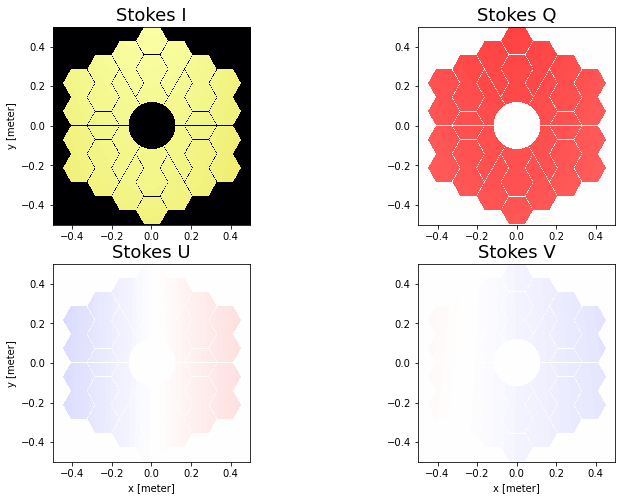

In [118]:
stokes_parameters = [partially_polarized_wavefront.I, partially_polarized_wavefront.Q, partially_polarized_wavefront.U, partially_polarized_wavefront.V]
titles = ['I', 'Q', 'U', 'V']

# The value that we use to normalize the stokes vector with.
max_val = np.max(stokes_parameters[0])

k=1
plt.figure(figsize=(12, 8))

for stokes_parameter, title in zip(stokes_parameters, titles):

    if max_val == 0:
        max_val = 1

    plt.subplot(2,2,k)

    if title == 'I':
        cmap = 'inferno'
        vmin = 0
        vmax = 1
    else:
        cmap = 'bwr'
        vmin = -1
        vmax = 1

    if title == 'U' or title == 'V':
        plt.xlabel('x [meter]')

    if title == 'I' or title == 'U':
        plt.ylabel('y [meter]')

    imshow_field(stokes_parameter / max_val, cmap=cmap, vmin=vmin, vmax=vmax)

    plt.title('Stokes ' + title)
    k += 1


In [119]:
# Measurements with half-wave plate cycles
# total duration of the measurement
measurement_duration = 8 # seconds

# number of times we go through a HWP cycle
HWP_cycles = 4

# integration time per measurement
delta_t = measurement_duration / (HWP_cycles * 4)

# counter for the state of the modulation loop
k = 0

# The arrays where the measurements are saved
measurements = Field(np.zeros((4, focal_grid.size)), focal_grid)
measurements_aberrated = Field(np.zeros((4, focal_grid.size)), focal_grid)

# looping through the time steps
for t in np.linspace(0, measurement_duration, HWP_cycles * 4):

    # rotating the HWP to its new position
    HWP.fast_axis_orientation = np.radians(HWP_positions[k])

    # we propagate the wavefront through the half-wave plate
    pupil_wavefront_2 = HWP.forward(partially_polarized_wavefront)

    # we propagate the wavefront through the linear polarizer
    pupil_wavefront_3 = polarizer.forward(pupil_wavefront_2)

    focal_wavefront = prop(pupil_wavefront_3)

    detector.integrate(focal_wavefront, dt=delta_t)

    # reading out the detector in the correct element of the measurement array
    measurements_aberrated[k,:] += detector.read_out()

    # Moving to the next HWP position
    k += 1

    # resetting the HWP to its intial position
    if k > 3:
        k = 0

# looping through the time steps
for t in np.linspace(0, measurement_duration, HWP_cycles * 4):

    # rotating the HWP to its new position
    HWP.fast_axis_orientation = np.radians(HWP_positions[k])

    # we propagate the wavefront through the half-wave plate
    pupil_wavefront_2 = HWP.forward(pupil_wavefront)

    # we propagate the wavefront through the linear polarizer
    pupil_wavefront_3 = polarizer.forward(pupil_wavefront_2)

    focal_wavefront = prop(pupil_wavefront_3)

    detector.integrate(focal_wavefront, dt=delta_t)

    # reading out the detector in the correct element of the measurement array
    measurements[k,:] += detector.read_out()

    # Moving to the next HWP position
    k += 1

    # resetting the HWP to its intial position
    if k > 3:
        k = 0


HWP position  1
Number of photons =  34369630

HWP position  2
Number of photons =  11456543

HWP position  3
Number of photons =  24058741

HWP position  4
Number of photons =  21767432


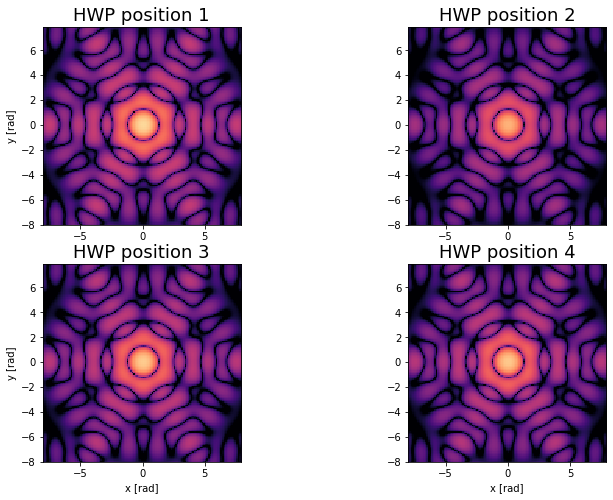

In [130]:
plt.figure(figsize=(12, 8))

max_val_meas = np.max(measurements)

for i in np.arange(4):
    plt.subplot(2,2,i+1)
    imshow_field(np.log10(measurements[i,:]),vmin=-0,vmax=6)

    if i > 1:
        plt.xlabel('x [rad]')

    if i == 0 or i == 2:
        plt.ylabel('y [rad]')

    print('\nHWP position ', i+1)
    print('Number of photons = ', int(np.sum(measurements[i,:])))

    plt.title('HWP position ' + str(i+1))

In [121]:
# defining the demodulation matrix
demodulation_matrix = np.zeros((4,4))

# demodulation for I
demodulation_matrix[0,:] = 0.25

# demodulation for Q
demodulation_matrix[1,0] = 0.5
demodulation_matrix[1,1] = -0.5

# demodulation for U
demodulation_matrix[2,2] = 0.5
demodulation_matrix[2,3] = -0.5

print('demodulation matrix = \n', demodulation_matrix)

demodulation matrix = 
 [[ 0.25  0.25  0.25  0.25]
 [ 0.5  -0.5   0.    0.  ]
 [ 0.    0.    0.5  -0.5 ]
 [ 0.    0.    0.    0.  ]]


In [122]:
photometry_aperture = circular_aperture(1)(focal_grid)

# generating the measurement vector by doing aperture photometry.
measurement_vector = np.array(np.sum(measurements[:,photometry_aperture==1], axis=1))
measurement_aberrated = np.array(np.sum(measurements_aberrated[:,photometry_aperture==1], axis=1))

# calculating the measured Stokes vector
stokes_measured = field_dot(demodulation_matrix, measurement_vector)
stokes_aberrated = field_dot(demodulation_matrix, measurement_aberrated)

print('Measured Stokes vector = \n', stokes_measured / stokes_measured[0])
print('With Polarization Aberrations = \n', stokes_aberrated / stokes_aberrated[0])

print('Input Stokes vector = \n', partially_polarized_wavefront.input_stokes_vector)


Measured Stokes vector = 
 [1.   0.5  0.05 0.  ]
With Polarization Aberrations = 
 [ 1.          0.70218356 -0.00544314  0.        ]
Input Stokes vector = 
 [1.   0.5  0.05 0.01]


<ipython-input-122-b806db38b794>:1: DeprecationWarning: circular_aperture is deprecated. Its new name is make_circular_aperture.
  photometry_aperture = circular_aperture(1)(focal_grid)


<ipython-input-52-108938655168>:2: RuntimeWarning: invalid value encountered in divide
  imshow_field(partially_polarized_wavefront.Q/partially_polarized_wavefront.I - pupil_wavefront.Q/pupil_wavefront.I)


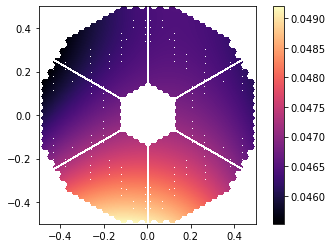

In [52]:
plt.figure()
plt.title('')
imshow_field(partially_polarized_wavefront.Q/partially_polarized_wavefront.I - pupil_wavefront.Q/pupil_wavefront.I)
plt.colorbar()
plt.show()

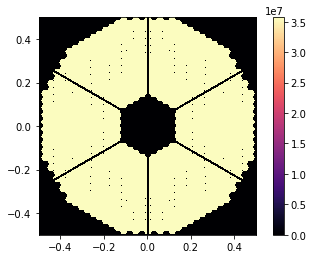

In [50]:
imshow_field(partially_polarized_wavefront.intensity)
plt.colorbar()